In [37]:
%pylab inline
plt.style.use("bmh")
import pandas as pd
import numpy as np
import pathlib
import matplotlib as mpl
import torch

import datetime
from training import forcast,retrieve_data,train,calculate_loss

from torch.utils.data import DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler

from torch import optim,device,cuda

from ElectricityLoadDataset import ElectricityLoadDataset
from Models import MQRNN
from utils import quantile_loss




Populating the interactive namespace from numpy and matplotlib


In [2]:


#device = device('cuda:0') if cuda.is_available() else device('cpu')

input_size = 1  # y
embed_size = 9 # x
hidden_size = 30  # for lstm: "both with a state dimension of 30"
context_size = 8  # for c_t/c_a
horizon = 24
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

samples = 100

batch_size = 32
random_seed = 42

print_every = 50
epochs = 30


## The model features - 9 calendar features

The night / day cycle varies between summer and winter (see graph below that illustrates that).

In the summer and winter, the daily cycle is changing.

Therefore add just a daily cycle and yearly cycle features are not enough to identify whole annual cycles.

For example, in the summer the consumption peak is in the afternoon and winter probably in the evening. Also, the difference between the peak and minimum of daily consumption is varying throughout the year.
The following variables together try to predict the full yearly sub-cycles.



**Full calendar features ($x_h,x_f$):**
1. yearly_cycle = np.sin(2 * np.pi * df.index.dayofyear / 366)

2. weekly_cycle= np.sin(2 * np.pi * df.index.dayofweek / 7)

3. daily_cycle= np.sin(2 * np.pi * df.index.hour / 24)

4. weekend= (df.index.dayofweek < 5).astype(float)

5. night = ((df.index.hour < 7) & (df.index.hour>21)).astype(float)

6. winter = ((df.index.month < 4) & (df.index.month > 10)).astype(float)

7. Holiday = ((df.index.is_year_end | df.index.is_year_start) | (( df.index.month==12) & (df.index.daysinmonth==25))).astype(float)

8. winter_daily_cycle =daily_cycle*winter
9. summer_daily_cycle =daily_cycle*(1-winter)


`calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle", "weekend", "night", "winter", "Holiday", "summer_daily_cycle", "winter_daily_cycle"]`




It should be noted that adding all nine features helps the prediction accuracy mainly when using a small sample. However, when the models are heavily trained and include 100 samples, these features contribute a little. However, we added them because they improve the model accuracy.

### Model with all 9 calendar_features

In [3]:

data_loaders = retrieve_data(samples=samples)
model = MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles)
#model = MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=4, factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=100, batch=32, printing training loss every 50*32=1600 samples
2021-03-08 16:03:16.475160 Starting epoch 1 / 30
2021-03-08 16:03:59.533962 t = 50, loss = 0.0590
2021-03-08 16:04:29.303345 t = 100, loss = 0.0505
2021-03-08 16:04:59.340259 t = 150, loss = 0.0450
2021-03-08 16:05:28.853318 t = 200, loss = 0.0501
2021-03-08 16:05:56.818841 t = 250, loss = 0.0553
2021-03-08 16:06:25.920572 t = 300, loss = 0.0403
2021-03-08 16:06:54.138108 t = 350, loss = 0.0361
2021-03-08 16:07:24.217021 t = 400, loss = 0.0443
2021-03-08 16:07:52.030584 t = 450, loss = 0.0340
2021-03-08 16:08:21.346181 t = 500, loss = 0.0480
2021-03-08 16:08:52.281568 t = 550, loss = 0.0330
2021-03-08 16:09:21.241120 t = 600, loss = 0.0285
2021-03-08 16:09:49.597772 t = 650, loss = 0.0421
2021-03-08 16:10:21.084917 t = 700, loss = 0.0338
2021-03-08 16:10:48.335375 t = 750, loss = 0.0311
2021-03-08 16:11:17.179232 t = 800, loss = 0.0350
2021-03-08 16:11:19.243711 Got average loss of (0.0448) last_lr = 

2021-03-08 17:27:48.666587 t = 800, loss = 0.0446
2021-03-08 17:27:50.916569 Got average loss of (0.0335) last_lr = 0.01
2021-03-08 17:27:50.918563 Starting epoch 10 / 30
2021-03-08 17:28:34.340995 t = 50, loss = 0.0290
2021-03-08 17:29:02.833793 t = 100, loss = 0.0267
2021-03-08 17:29:29.651073 t = 150, loss = 0.0236
2021-03-08 17:29:57.860628 t = 200, loss = 0.0282
2021-03-08 17:30:28.238386 t = 250, loss = 0.0335
2021-03-08 17:30:56.662367 t = 300, loss = 0.0282
2021-03-08 17:31:26.068722 t = 350, loss = 0.0377
2021-03-08 17:31:55.021293 t = 400, loss = 0.0304
2021-03-08 17:32:23.828250 t = 450, loss = 0.0312
2021-03-08 17:32:53.001226 t = 500, loss = 0.0423
2021-03-08 17:33:21.302930 t = 550, loss = 0.0317
2021-03-08 17:34:09.567360 t = 600, loss = 0.0269
2021-03-08 17:35:05.376443 t = 650, loss = 0.0310
2021-03-08 17:36:00.422730 t = 700, loss = 0.0283
2021-03-08 17:36:28.631976 t = 750, loss = 0.0409
2021-03-08 17:36:57.380089 t = 800, loss = 0.0360
2021-03-08 17:37:00.552604 Got

2021-03-08 18:42:20.385832 t = 600, loss = 0.0294
2021-03-08 18:43:03.253689 t = 650, loss = 0.0280
2021-03-08 18:43:33.032561 t = 700, loss = 0.0311
2021-03-08 18:44:02.144703 t = 750, loss = 0.0352
2021-03-08 18:44:29.720963 t = 800, loss = 0.0290
2021-03-08 18:44:32.271131 Got average loss of (0.0316) last_lr = 0.0001
2021-03-08 18:44:32.274123 Starting epoch 19 / 30
2021-03-08 18:45:20.067912 t = 50, loss = 0.0306
2021-03-08 18:45:48.698339 t = 100, loss = 0.0277
2021-03-08 18:46:19.326429 t = 150, loss = 0.0262
2021-03-08 18:46:53.604269 t = 200, loss = 0.0312
2021-03-08 18:47:22.225920 t = 250, loss = 0.0269
2021-03-08 18:47:52.710390 t = 300, loss = 0.0681
2021-03-08 18:48:21.162297 t = 350, loss = 0.0286
2021-03-08 18:48:50.695312 t = 400, loss = 0.0263
2021-03-08 18:49:20.858643 t = 450, loss = 0.0305
2021-03-08 18:49:50.749701 t = 500, loss = 0.0260
2021-03-08 18:50:19.547085 t = 550, loss = 0.0245
2021-03-08 18:50:49.637851 t = 600, loss = 0.0350
2021-03-08 18:51:20.169200 t

2021-03-08 19:54:59.329852 t = 450, loss = 0.0308
2021-03-08 19:55:29.100331 t = 500, loss = 0.0295
2021-03-08 19:56:00.274474 t = 550, loss = 0.0456
2021-03-08 19:56:28.851063 t = 600, loss = 0.0352
2021-03-08 19:56:58.510737 t = 650, loss = 0.0304
2021-03-08 19:57:27.521927 t = 700, loss = 0.0365
2021-03-08 19:57:55.315471 t = 750, loss = 0.0248
2021-03-08 19:58:25.933870 t = 800, loss = 0.0226
2021-03-08 19:58:28.725404 Got average loss of (0.0315) last_lr = 1e-05
2021-03-08 19:58:28.729389 Starting epoch 28 / 30
2021-03-08 19:59:15.705716 t = 50, loss = 0.0262
2021-03-08 19:59:49.068055 t = 100, loss = 0.0277
2021-03-08 20:00:23.194786 t = 150, loss = 0.0285
2021-03-08 20:00:53.298221 t = 200, loss = 0.0284
2021-03-08 20:01:27.089848 t = 250, loss = 0.0396
2021-03-08 20:02:02.959054 t = 300, loss = 0.0223
2021-03-08 20:02:34.657280 t = 350, loss = 0.0274
2021-03-08 20:03:06.954902 t = 400, loss = 0.0243
2021-03-08 20:03:39.626871 t = 450, loss = 0.0258
2021-03-08 20:04:14.720014 t 

In [48]:
torch.save(model.state_dict(), pathlib.Path("models").joinpath("epoch_{0}_loss_{1}".format(30, 0.0315)))


In [33]:
      
model.eval()
loss = 0A
for t, (enc_data, dec_data) in enumerate(dataiter):
  loss += calculate_loss(model, enc_data, dec_data).item()
loss = loss / (t+1)
print("\n","The test average loss:",calculate_loss(model, enc_data, dec_data).detach().numpy().round(4))


 The test average loss: 0.0262


In [38]:
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
#forcast=forcast(model, enc_data, dec_data, quantiles)
forcast=forcast(model, enc_data, dec_data, quantiles = [0.01, 0.25, 0.5, 0.75, 0.99],input_size = 1,GRAPH_DIR ="graphs")


(-0.5, 431.5, 287.5, -0.5)

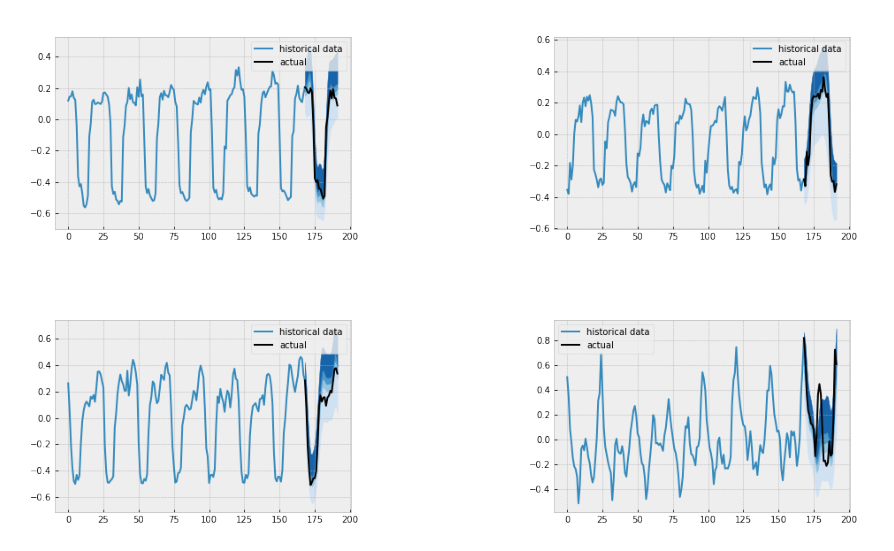

In [41]:


import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]
GRAPH_DIR="graphs" 


img1=mpimg.imread( pathlib.Path(GRAPH_DIR).joinpath(str(1)+".png")) 
img2=mpimg.imread( pathlib.Path(GRAPH_DIR).joinpath(str(2)+".png")) 
img3=mpimg.imread( pathlib.Path(GRAPH_DIR).joinpath(str(3)+".png")) 
img4=mpimg.imread( pathlib.Path(GRAPH_DIR).joinpath(str(4)+".png")) 



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(14,8))
fig.tight_layout()
ax1.imshow(img1)
ax1.axis("off")
ax2.imshow(img2)
ax2.axis("off")
ax3.imshow(img3)
ax3.axis("off")
ax4.imshow(img4)
ax4.axis("off")

## The average consumption across all 370 households - a graphical summary

note: the average not include zeros  only

In [42]:
eldata = pd.read_csv('data\LD2011_2014.txt',
                 parse_dates=[0],
                 delimiter=";",
                 decimal=",")
eldata.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)


eldata=eldata.resample('H', on='timestamp').mean().reset_index()

el_mean=eldata[eldata!=0].set_index("timestamp").mean(axis=1)


## An illustration of the winter-summer cycles




The following graph shows the average consumption over several years.
The colors are arbitrary, illustrating the summer - winter seasons.



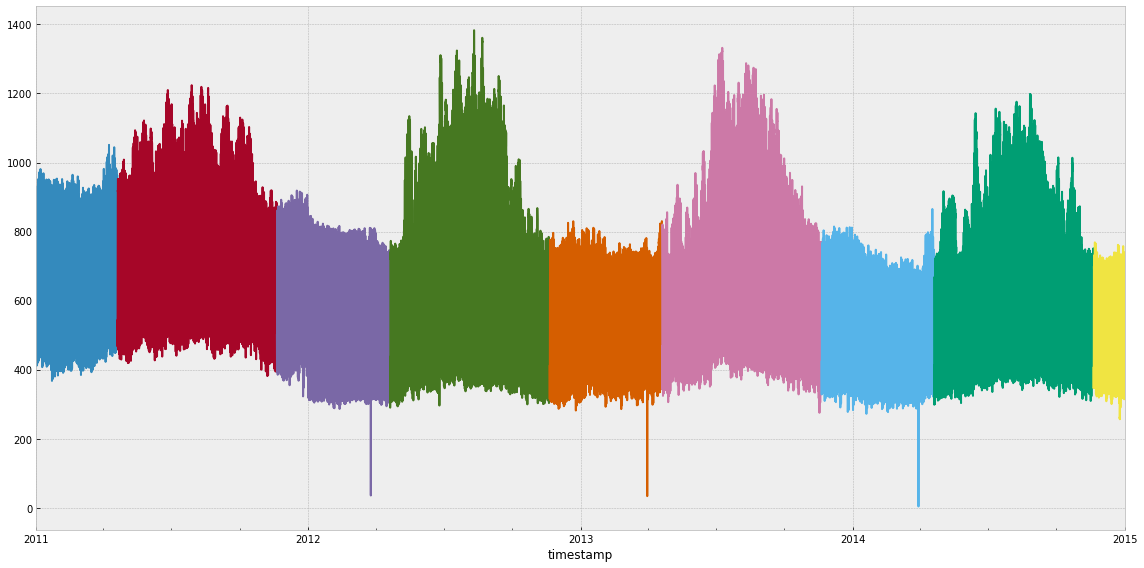

In [43]:
plt.figure(figsize=(16,8))
el_mean.loc["2011-1-1":"2011-4-19"].plot()
el_mean.loc["2011-4-20":"2011-11-19"].plot()
el_mean.loc["2011-11-20":"2012-4-19"].plot()
el_mean.loc["2012-4-20":"2012-11-19"].plot()

el_mean.loc["2012-11-20":"2013-4-19"].plot()
el_mean.loc["2013-4-20":"2013-11-19"].plot()

el_mean.loc["2013-11-20":"2014-4-19"].plot()
el_mean.loc["2014-4-20":"2014-11-19"].plot()
el_mean.loc["2014-11-20":"2015-1-31"].plot()


plt.tight_layout()

The minimum daily consumption has moderate yearly cycles, and the maximum has high cycles.